# 🎙️ Grammar Scoring Engine for Spoken English: Part - 1

The objective of this project is to develop an automated **Grammar Scoring Engine** capable of evaluating spoken English proficiency. By analyzing speech patterns and acoustic signatures, the system predicts a continuous grammar score on a scale of **0 to 5**.

## 🎯 Project Goals

The pipeline is designed to be end-to-end, transforming raw vocal data into actionable linguistic insights:

1. **Audio Input:** Process 45-60 second speech samples.
2. **Feature Extraction:** Convert raw waveforms into **Mel-frequency Cepstral Coefficients (MFCCs)** to capture the essential characteristics of the speaker's voice and articulation.
3. **Score Prediction:** Utilize machine learning models to map these features to a continuous fluency and grammar metric.

---

## 🛠️ Step 1: MFCC Feature Extraction

In this section, we will extract **MFCC features** from the audio files. MFCCs are crucial because they represent the short-term power spectrum of a sound and mimic the way the human ear perceives frequency, making them highly effective for speech and grammar recognition tasks.


## Import the libraries

In [ ]:
import numpy as np         # High-performance mathematical operations on arrays
import pandas as pd        # Structured data manipulation and CSV handling
import librosa             # Leading library for audio and music analysis
import librosa.display     # Specialized tools for plotting waveforms and spectrograms
import seaborn as sns      # Statistical data visualization built on top of Matplotlib
import matplotlib.pyplot as plt  # Core plotting engine for creating figures
from IPython.display import Audio, display # Enables interactive audio playback in the notebook
from tqdm import tqdm      # Visual progress bars for loops and long-running tasks
import os                  # Standard library for interacting with the operating system/file paths

## Load the dataset
lets load from kaggle for faster access

### Read the path from kaggle

In [ ]:
from google.colab import userdata
dataset = userdata.get('DATASET')

In [ ]:
import kagglehub
path = kagglehub.dataset_download(dataset)

Using Colab cache for faster access to the 'shl-dataset' dataset.


### Load the csv files
let's read data and create pandas dataframe

In [ ]:
train_df = pd.read_csv(f"{path}/dataset/train.csv")
test_df = pd.read_csv(f"{path}//dataset/test.csv")

## EDA
lets get acquainted the data

In [6]:
# view first 5 rows
train_df.head()

,filename,label
0,audio_1261.wav,1.0
1,audio_942.wav,1.5
2,audio_1110.wav,1.5
3,audio_1024.wav,1.5
4,audio_538.wav,2.0


In [7]:
# check the shape of data
train_df.shape

(444, 2)

In [8]:
# check for nan values
train_df.isna().sum()

,0
filename,0
label,0


### distribution of data

In [9]:
train_df.label.value_counts()

,count
label,
5.0,110
3.0,87
2.0,70
4.5,58
4.0,52
2.5,40
3.5,23
1.5,3
1.0,1


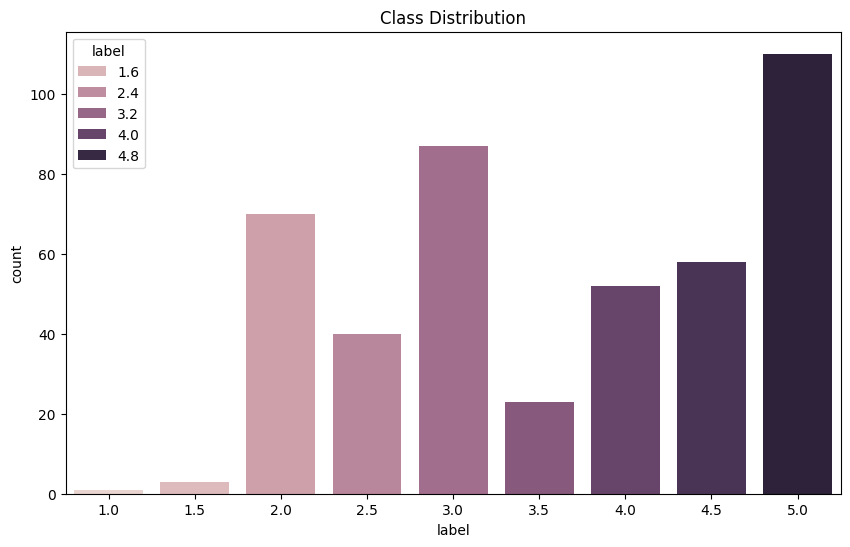

In [15]:
# let's visual if its imbalance
plt.figure(figsize=(10,6))
sns.countplot(x='label', data=train_df, hue='label')  # palette gives different colors
plt.title("Class Distribution")
plt.show()

>  Insight:
- **Dominant Class**:  
  - Label **5.0** has the highest frequency (110), making it the majority class.  
  - This suggests a **positive skew** toward higher scores.

- **Moderate Classes**:  
  - Labels like **3.0, 2.0, 4.5, 4.0** have decent representation (40–87 counts).  
  - These form the bulk of the mid-range distribution.

- **Minority Classes**:  
  - Labels **1.0** and **1.5** are extremely rare (only 1 and 3 samples).  
  - These are **severe outliers** and could cause issues in training if treated equally.

>>Models may overfit to the majority class (5.0) and underperform on rare classes (1.0, 1.5). Even though it's regression, the skew in target values acts like class imbalance in classification.

### Familiar with audio file

In [17]:
# lets take sample audio path
example_path = '/kaggle/input/shl-dataset/dataset/audios_train/audio_77.wav'

In [18]:
# Load the audio file
# y -> audio time series (numpy array)
# sr -> sampling rate (samples per second)
y, sr = librosa.load(example_path)

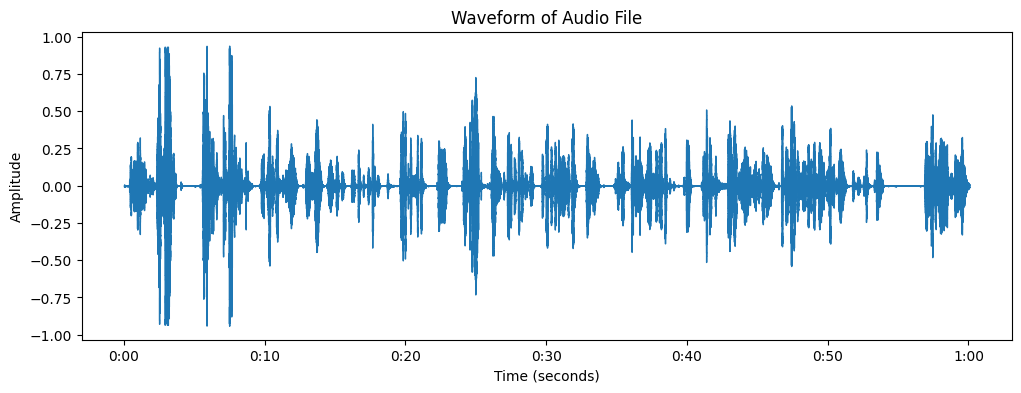

In [19]:
# Plot the waveform
plt.figure(figsize=(12, 4))
librosa.display.waveshow(y, sr=sr)   # visualize the audio signal
plt.title("Waveform of Audio File")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.show()

#### Spectogram view

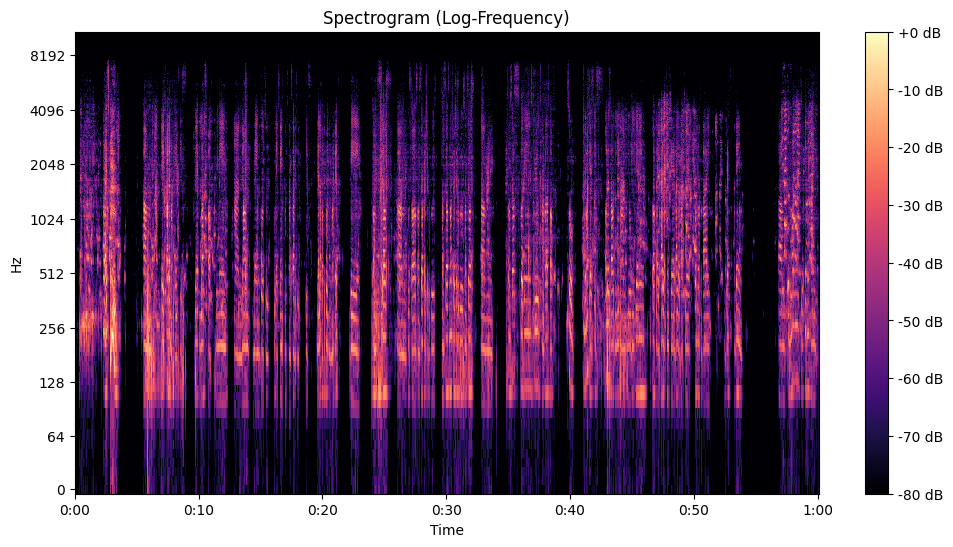

In [21]:
# Compute STFT (complex-valued: contains magnitude + phase)
S = librosa.stft(y)

# Convert to decibels using magnitude only
D = librosa.amplitude_to_db(np.abs(S), ref=np.max)

# Plot spectrogram
plt.figure(figsize=(12, 6))
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram (Log-Frequency)")
plt.show()

#### Play/listen the audio

In [22]:
# create function for reusability
def play_audio(path: str):
    wave, sr = librosa.load(path)
    print("Playing audio...")
    # Display the audio player widget
    display(Audio(data=wave, rate=sr))

In [23]:
# play the audio
play_audio(example_path)

Output hidden; open in https://colab.research.google.com to view.

In [24]:
# create function for reusability
def get_amplitude_sr(filename: str):
    """Get audio time series and sample rate"""
    y, sr = librosa.load(filename)
    return y, sr

## 🏗️ Feature Extraction: MFCC Analysis

Raw audio data is too high-dimensional for most machine learning models to process efficiently. To capture the linguistic and acoustic nuances required for grammar scoring, we transform the 1D waveform into **Mel-frequency Cepstral Coefficients (MFCCs)**.

### 🔍 The Process

1. **Amplitude & Sample Rate (sr):** We load the raw signal to obtain the amplitude (vibration intensity) and the sampling rate (the number of data points recorded per second).
2. **MFCC Calculation:** This step converts the signal from the **Time Domain** to the **Frequency Domain**. We use the **Mel Scale**, which mimics human hearing by prioritizing lower frequencies where speech nuances are most distinct.
* *Note:* We typically extract 13 coefficients, as these provide a compact representation of the spectral envelope (the "shape" of the sound).


3. **Temporal Aggregation (Mean(or `standard deviation`)):** Since audio files vary in length, the resulting MFCC matrix has a variable width. By taking the **mean across the time axis (axis=1)**, we compress the data into a fixed-length feature vector that represents the "average" acoustic signature of the entire 45-60 second clip.

### Create function to extract mfcc

In [25]:
def get_mfcc_features(path: str):
    """
    Extracts fixed-length MFCC features from an audio file.

    1. Loads audio to get amplitude (y) and sample rate (sr).
    2. Computes a 13-band MFCC matrix.
    3. Flattens the time dimension by taking the mean.
    """
    y, sr = get_amplitude_sr(path)

    # Extract MFCCs
    # n_mfcc=13 is the standard for speech processing (12 coefficients + 1 for energy)
    N_MFCC = 13
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC)

    # Aggregate by taking the mean across the time axis (axis=1)
    # This ensures every audio file results in a vector of length 13
    fixed_feature_vector = np.mean(mfccs, axis=1)

    return fixed_feature_vector

### Visualize extracted mfcc

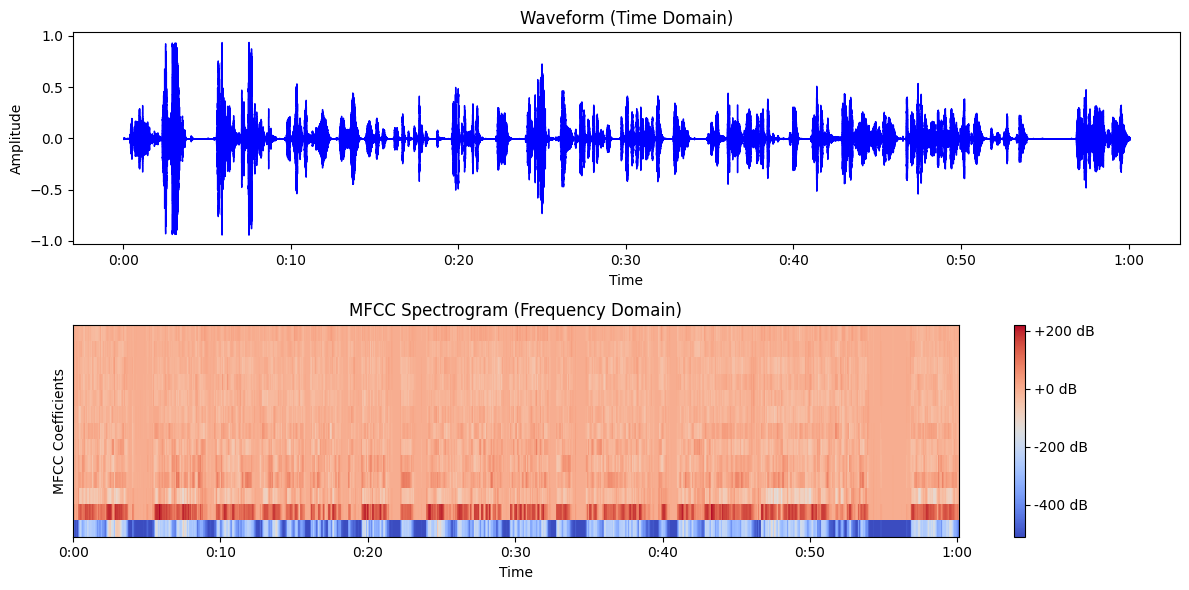

In [26]:
y, sr = get_amplitude_sr(example_path)  # Load the data

mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)   # Extract MFCCs

plt.figure(figsize=(12, 6))  # set figure size for Plotting

# Plot Waveform
plt.subplot(2, 1, 1)
librosa.display.waveshow(y, sr=sr, color='blue')
plt.title('Waveform (Time Domain)')
plt.ylabel('Amplitude')

# Plot MFCC
plt.subplot(2, 1, 2)
librosa.display.specshow(mfccs, x_axis='time', sr=sr)
plt.colorbar(format='%+2.0f dB')
plt.title('MFCC Spectrogram (Frequency Domain)')
plt.ylabel('MFCC Coefficients')

plt.tight_layout()
plt.show()

#### Here is a breakdown of what the data is telling us from above output:

##### 1. Speech Pacing and Fluency

In the **Waveform (Time Domain)**, we see distinct "bursts" of energy followed by flat lines (silence).

* **Insight:** There is a significant pause between **0:53 and 0:57**. In a grammar/fluency task, frequent or long silences like this often correlate with lower scores, as they may indicate a speaker struggling to find the right words or correct their syntax.
* **Action:** The model will likely use the variance in these MFCC features over time to detect these hesitations.

##### 2. Spectral Energy Distribution

Looking at the **MFCC Spectrogram**, the bottom-most coefficients (the dark red band) show the highest energy.

* **Insight:** MFCC index 0 represents the **energy/loudness** of the signal. The fact that it remains consistent during speech segments but drops during pauses confirms your preprocessing is capturing the "speech vs. silence" relationship well.
* **Insight:** The higher coefficients (top of the spectrogram) are lighter/more uniform. This means most of the "information" regarding the speaker's articulation is contained in the first few coefficients.

##### 3. Consistency and Noise

The spectrogram looks relatively "clean" (the blue areas during silences are quite distinct from the red/orange during speech).

* **Insight:** This indicates a high **Signal-to-Noise Ratio (SNR)**. There isn't much background hum or static.
* **Impact:** This is great news for your machine learning model; the features extracted will be "pure" speech signals rather than environmental noise, which leads to more accurate scoring.

### 4. The Effect of "Mean Averaging"

You mentioned taking the `np.mean(axis=1)` for your feature vector.

* **Insight:** By averaging that entire 1-minute spectrogram into a single vector of 13 numbers, you are capturing the **average "texture"** of the person's voice and their general pronunciation patterns.
* **Trade-off:** While this is efficient, you lose the *timing* of the pauses. If the model struggles, you might later consider adding the **Standard Deviation** (`np.std`) of the MFCCs to capture how much the speaker's tone or pace fluctuates.

### Create DataFrame
now we will generate pandas dataframe

In [33]:
def get_mfcc_features_df(files: list, base_path: str = "/kaggle/input//shl-dataset/dataset/audios_train"):
    """
    Iterates through audio files, extracts MFCC features, and returns a structured DataFrame.

    Args:
        files (list): List of filenames (e.g., ['audio1.wav', 'audio2.wav']).
        base_path (str): The directory where audio files are stored.

    Returns:
        pd.DataFrame: A DataFrame where each row is the 13-feature vector for an audio file.
    """
    feature_list = []

    # tqdm provides a progress bar to track extraction for large datasets
    for file in tqdm(files, desc="Extracting MFCCs"):
        # Construct the absolute path to the audio file
        full_path = os.path.join(base_path, file)

        # Extract the mean MFCC vector (length 13)
        features = get_mfcc_features(full_path)

        # Append to list (more memory-efficient than pd.concat in a loop)
        feature_list.append(features)

    # Create the final DataFrame
    # Columns are named mfcc_0, mfcc_1, etc. for better identification
    column_names = [f'mfcc_{i}' for i in range(len(feature_list[0]))]
    df = pd.DataFrame(feature_list, columns=column_names)

    return df

In [34]:
# lets test for five rows
get_mfcc_features_df(train_df.head().filename.values)

Extracting MFCCs: 100%|██████████| 5/5 [00:00<00:00,  7.33it/s]


,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12
0,-491.022156,50.908745,5.274312,13.072773,0.288933,6.038390,-4.117104,-2.227430,0.231767,-4.312546,-2.723403,-2.253050,-1.958869
1,-429.440552,32.125301,-4.888645,10.810472,-12.059523,-1.756536,-7.439040,-4.322148,-2.530457,-5.752120,1.742423,-4.106583,-3.020200
2,-484.911224,61.282734,-4.729174,8.597246,7.826371,-1.465078,-2.612562,-0.756487,-3.777642,-2.300814,0.755517,-4.159078,-3.003711
3,-417.125244,92.675316,-7.478523,17.033480,11.358152,-2.826056,-1.129248,1.558352,-6.311178,-3.420260,-0.043829,-6.205880,-3.747921
4,-321.468414,114.073730,-14.037630,3.440586,-1.315021,-5.990539,-8.953232,-8.200576,-8.254661,-4.468946,-6.428641,-1.374519,-2.587344


lets create and save dataframe as csv for later use

In [35]:
df = get_mfcc_features_df(train_df.filename.values)
df.to_csv("mfcc_features.csv", index=False)

Extracting MFCCs: 100%|██████████| 444/444 [01:24<00:00,  5.26it/s]


In [36]:
# Verify the saved features
check_df = pd.read_csv("mfcc_features.csv")
print(f"Dataset Shape: {check_df.shape}")
check_df.head()

Dataset Shape: (444, 13)


,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12
0,-491.02216,50.908745,5.274312,13.072773,0.288932,6.038390,-4.117104,-2.227430,0.231767,-4.312546,-2.723403,-2.253050,-1.958869
1,-429.44055,32.125300,-4.888645,10.810472,-12.059523,-1.756536,-7.439040,-4.322148,-2.530457,-5.752120,1.742423,-4.106583,-3.020200
2,-484.91122,61.282734,-4.729174,8.597246,7.826371,-1.465078,-2.612562,-0.756487,-3.777642,-2.300814,0.755517,-4.159078,-3.003712
3,-417.12524,92.675316,-7.478523,17.033480,11.358152,-2.826056,-1.129248,1.558352,-6.311178,-3.420260,-0.043829,-6.205880,-3.747921
4,-321.46840,114.073730,-14.037630,3.440586,-1.315021,-5.990539,-8.953232,-8.200576,-8.254661,-4.468946,-6.428641,-1.374519,-2.587344


## ✅ Step 1 Complete: MFCC Feature Extraction

We have successfully transformed raw audio signals into a structured dataset ready for Machine Learning.

### 📝 Summary of Progress:

* **Data Loading:** Processed spoken English samples.
* **Feature Extraction:** Utilized `librosa` to compute 13 **Mel-frequency Cepstral Coefficients (MFCCs)** per file.
* **Dimensionality Reduction:** Aggregated temporal data by calculating the **mean** of each coefficient, resulting in a fixed-length feature vector.
* **Persistence:** Exported the processed features to `mfcc_features.csv` to ensure a fast, reproducible pipeline.
